C:\Users\Andrew\AppData\Local\Temp\ipykernel_19028\443621707.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  ax[0].imshow(lr[10].T)


<Figure size 640x480 with 0 Axes>

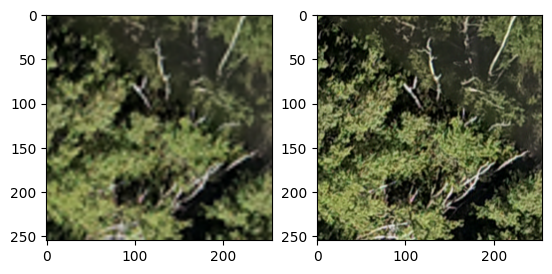

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from data import SRCNNDataset
import torch

data = np.load("../256dataset_images_small.npy")
data = np.transpose(data, (0, 2, 3, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure()
f, ax = plt.subplots(1, 2)

dataset = SRCNNDataset(hr_images=data, scale_factor=3)
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

lr, hr = next(iter(train_dataloader))

ax[0].imshow(lr[10].T)
ax[1].imshow(hr[10].T)



Epoch 1 / 1000
Training loss: 0.08193754009096332 | Validation loss: 0.010112345574556716 | PSNR: 19.976836127964535 | Time: 80.90754723548889
Epoch 2 / 1000
Training loss: 0.009831070708858657 | Validation loss: 0.009817053663677402 | PSNR: 20.106168938951118 | Time: 71.53111815452576
Epoch 3 / 1000
Training loss: 0.009745697436627255 | Validation loss: 0.009757038508541881 | PSNR: 20.13286413914454 | Time: 71.96100807189941
Epoch 4 / 1000
Training loss: 0.009686003936501387 | Validation loss: 0.009697433760655778 | PSNR: 20.159554706988633 | Time: 72.45714092254639
Epoch 5 / 1000
Training loss: 0.009626196700692391 | Validation loss: 0.009637757300931428 | PSNR: 20.186442057623164 | Time: 72.21718859672546
Epoch 6 / 1000
Training loss: 0.009566074500935266 | Validation loss: 0.009577541382584188 | PSNR: 20.21373897254615 | Time: 71.84103989601135
Epoch 7 / 1000
Training loss: 0.009505377450664144 | Validation loss: 0.009516781798031714 | PSNR: 20.24145841388069 | Time: 72.00252461433

<Figure size 640x480 with 0 Axes>

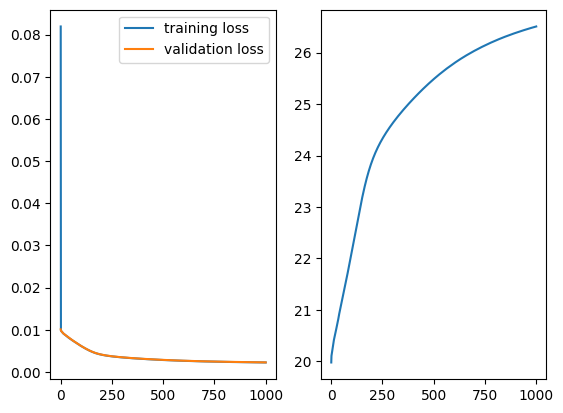

In [2]:
import time
from model import SRCNN
from util import psnr
import torch.backends.cudnn as cudnn

def train(model, train_set, validation_set, epochs, lr):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    training_loss = []
    validation_loss = []
    psnrs = []
    
    cudnn.benchmark = True
    torch.cuda.empty_cache()

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch} / {epochs}")
        t0 = time.time()
        epoch_train_loss = 0
        for index, batch in enumerate(train_set):
            print(f"Batch {index} / {len(train_set)-1}", end="\r")

             
            features = features.to(device)
            labels = labels.to(device)
            y_pred = model(features)
            loss = loss_function(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss+=loss.cpu().item()
        training_loss.append(epoch_train_loss/len(train_set))

        epoch_validation_loss = 0
        epoch_validation_psnr = 0
        with torch.no_grad():
            for index, batch in enumerate(validation_set):
                print(f"Validation Batch {index} / {len(validation_set)-1}", end="\r")
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                
                y_pred = model(features)
                loss = loss_function(y_pred, labels)

                epoch_validation_loss+=loss.cpu().item()
                epoch_validation_psnr+=psnr(y_pred, labels)
            validation_loss.append(epoch_validation_loss/len(validation_set))
            psnrs.append(epoch_validation_psnr/len(validation_set))
        
        print(f"Training loss: {epoch_train_loss/len(train_set)} | Validation loss: {epoch_validation_loss/len(validation_set)} | PSNR: {epoch_validation_psnr/len(validation_set)} | Time: {time.time()-t0}")
    
    plt.figure()
    f, ax = plt.subplots(1, 2)
    ax[0].plot(range(1, epochs+1), training_loss, label="training loss")
    ax[0].plot(range(1, epochs+1), validation_loss, label="validation loss")
    ax[1].plot(range(1, epochs+1), psnrs, label="PSNR")
    ax[0].legend(loc='best')
    plt.show()

model = SRCNN()
model = model.to(device)
train(model, train_dataloader, validation_dataloader, epochs=1000, lr=0.0001)
torch.save(model, "SRCNN_1000epochs.pt")


In [ ]:
# Try to speed up training? If possible
    # Do we have access to strong GPUs...
# Train for 1000+ epochs
# Try 9-1-5
# Increase learning rate - try Adam
# Adjust scale?
# Compare with trained srcnn / try pretraining

C:\Users\Andrew\AppData\Local\Temp\ipykernel_19028\3848311546.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_models/SRCNN_1000epochs.pt")


Loss: 0.0022509728383738547 | SRCNN PSNR: 26.55646554867934 | Bicubic PSNR: 26.89282309067109


<Figure size 8000x8000 with 0 Axes>

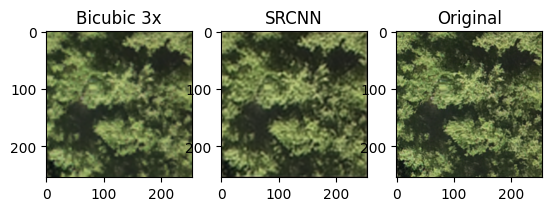

In [23]:
import random


def eval(model, test_set):
    total_loss = 0
    srcnn_psnr = 0
    bicubic_psnr = 0
    loss_function = torch.nn.MSELoss()

    with torch.no_grad():
        lr, hr = next(iter(test_set))
        lr = lr.to(device)
        hr = hr.to(device)

        plt.figure(figsize=(100,100),dpi=80)
        f, ax = plt.subplots(1, 3)
        index = random.randint(16)
        pred = model(lr[index])
        ax[0].imshow(lr[index].cpu().T)
        ax[0].set_title("Bicubic 3x")
        ax[1].imshow(pred.cpu().T)
        ax[1].set_title("SRCNN")
        ax[2].imshow(hr[index].cpu().T)
        ax[2].set_title("Original")

        for idx, batch in enumerate(test_set):
            print(f"Batch: {idx+1} / {len(test_set)}", end="\r")
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            y_pred = model(features)
            total_loss += loss_function(y_pred, labels).item()
            srcnn_psnr += psnr(y_pred, labels)
            bicubic_psnr += psnr(features, labels)
    print(f"Loss: {total_loss/len(test_set)} | SRCNN PSNR: {srcnn_psnr/len(test_set)} | Bicubic PSNR: {bicubic_psnr/len(test_set)}")

model = SRCNN()
model = torch.load("trained_models/SRCNN_1000epochs.pt")
eval(model, test_dataloader)
